In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 


In [2]:
figformat = 'svg'

In [3]:
dataset_asimov = Dataset_load.create_asimov(cutoff = True)
dataset_load = Dataset_load.create_asimov(cutoff = True)

In [4]:
biass = [-0.1, 0.0, 0.1]
bias_assumed = 0.1
sigmass = [0]


In [5]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution = s,
                        rnd = False,
                        e_reco_creation=10,
                        cutoff=True)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(10)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.e_reco_n = 10
    

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((4,4))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/zero**2, 1/zero**2, 1/zero**2])

    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    
    return dataset_conv, dataset_conv_N

datasets_conv =[]
datasets_conv_N =[]

for b in biass:
    dataset_conv, dataset_conv_N  = create_dataset(b, sigmass[0])
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    


In [6]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

<WCSAxesSubplot: >

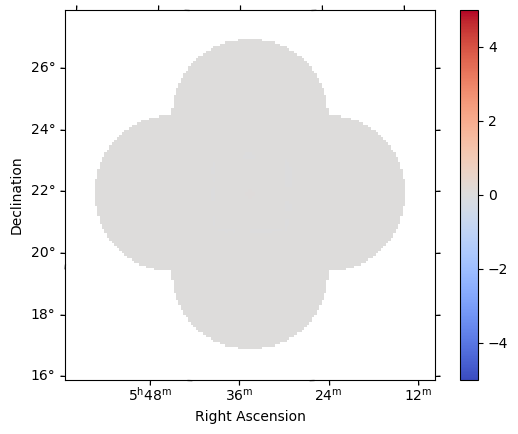

In [7]:
d = dataset_conv_N
d.plot_residuals_spatial()

In [8]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


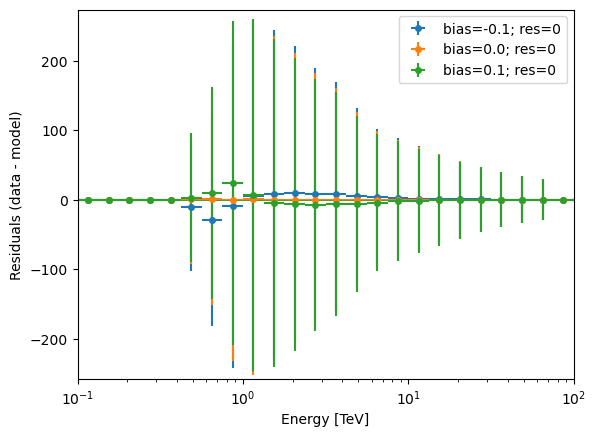

In [9]:
fig, ax = plt.subplots()
i = 0

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        #d = datasets_conv_N_fine[i]
        #d.plot_residuals_spectral(ax =ax, color= colors[1], 
        #            label = f"bias={b}; res={s}")
        i += 1
ax.legend()

fig.savefig(f"plots/2_Residual_pre_fit.svg")

In [12]:
npreds_pre_fit = []
npreds_pre_fit_N = []
i =0
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        i += 1

In [14]:
color_standard = 'mediumvioletred'; color_standard_e = 'palevioletred' #mediumvioletred
color_nui = 'midnightblue'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


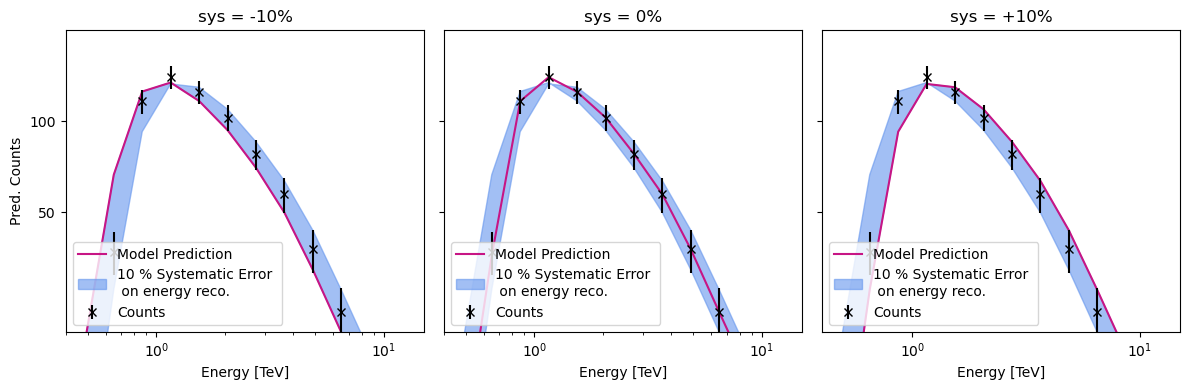

In [15]:

fig,ax = plt.subplots(1,3, sharey = True, figsize =  (12,4))

ax[0].plot(energy,npreds_pre_fit[0], label = "Model Prediction", color = color_standard)
ax[1].plot(energy,npreds_pre_fit[1], label = "Model Prediction", color = color_standard)
ax[2].plot(energy,npreds_pre_fit[2], label = "Model Prediction", color = color_standard)

for a in ax:
    a.fill_between(energy, npreds_pre_fit[0], npreds_pre_fit[2],
                 color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy reco.")
    a.errorbar(energy, sum_e(d.counts.data-d.background.data), 
             yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
            fmt = 'x', label = "Counts", color = 'black')

        
    a.loglog()
    a.legend(loc = 'lower left')
    a.set_xlabel("Energy [TeV]")
    a.set_ylim(2e1, 2e2)
    a.set_yticks([50,100], ['50', '100'])
    a.set_xlim(0.4, 15)
ax[0].set_ylabel("Pred. Counts")
ax[0].set_title("sys = -10%"); ax[1].set_title("sys = 0%"); ax[2].set_title("sys = +10%"); 

plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"plots/2_Npred.svg")


corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │              Nfcn = 756              │
│ EDM = 0.00372 (Goal: 2e-06)      │            time = 8.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │             Nfcn = 1595              │
│ EDM = 0.00232 (Goal: 2e-06)      │           time = 378.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │              Nfcn = 801              │
│ EDM = 0.03 (Goal: 2e-06)         │           time = 188.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────

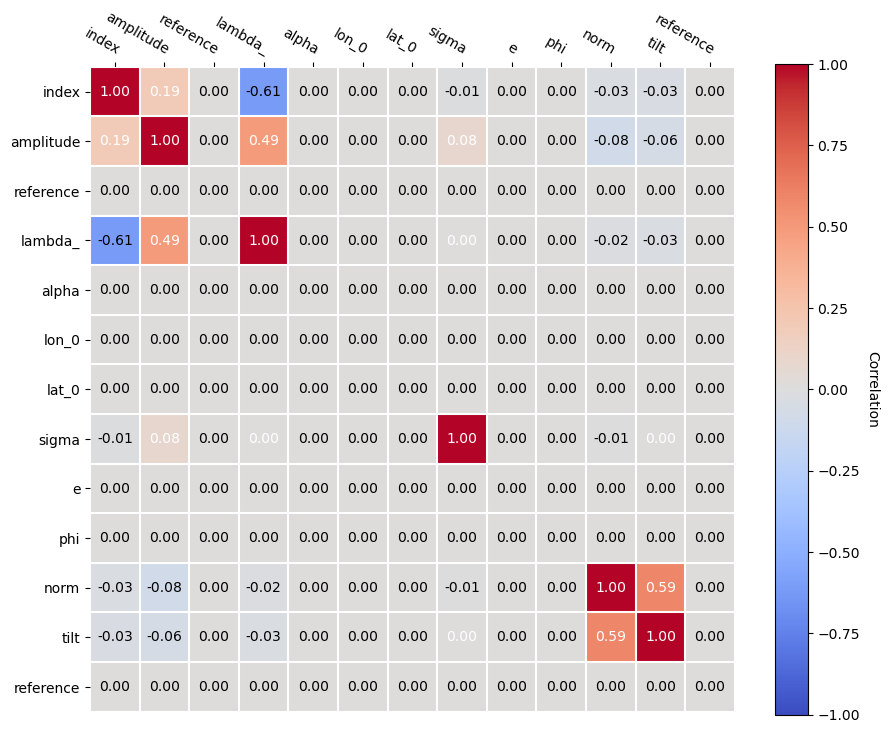

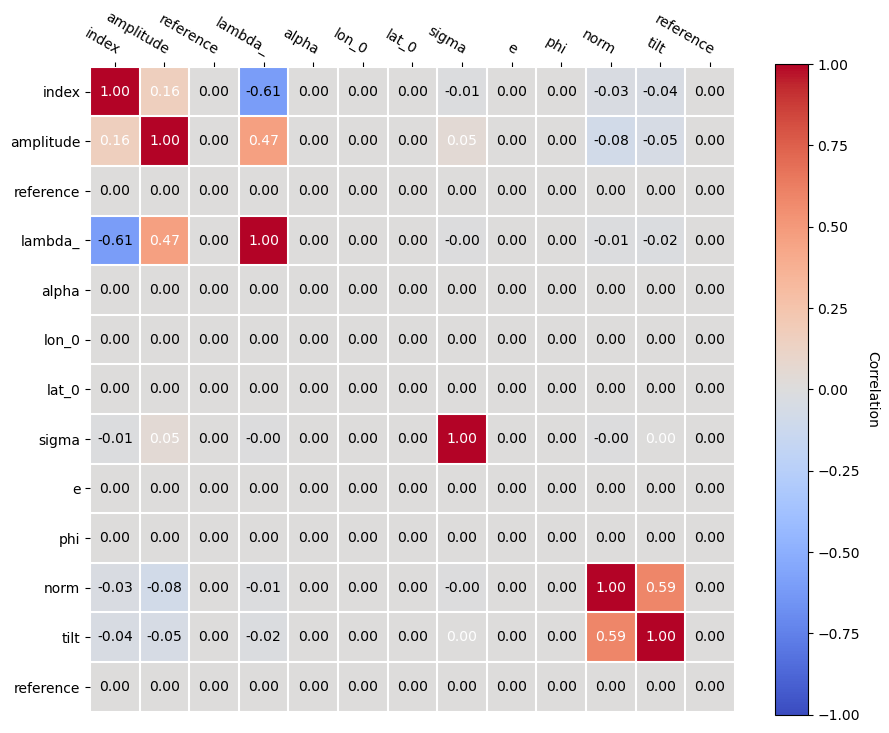

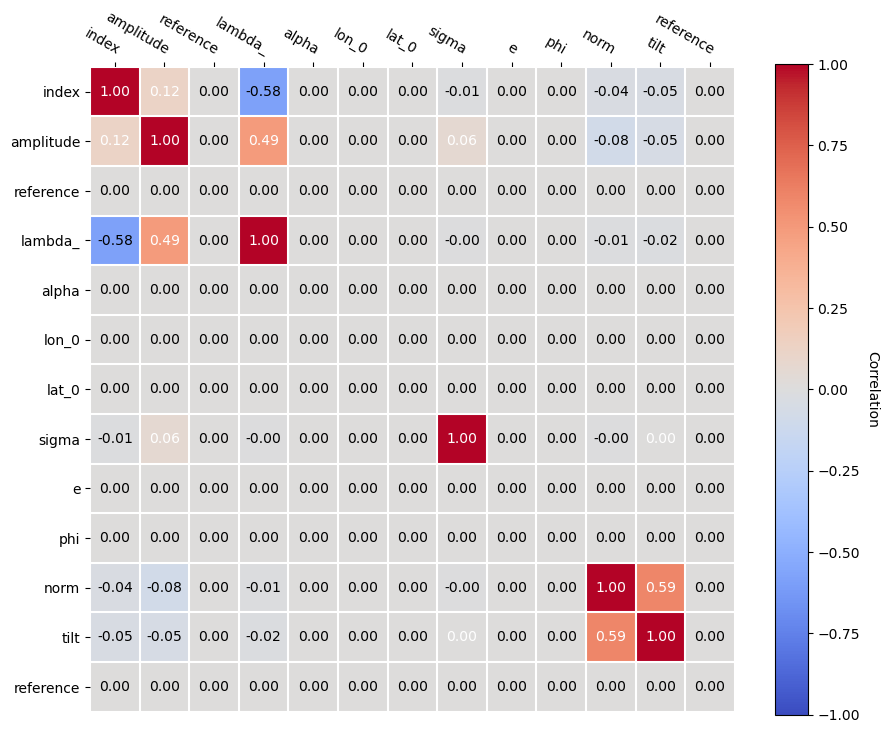

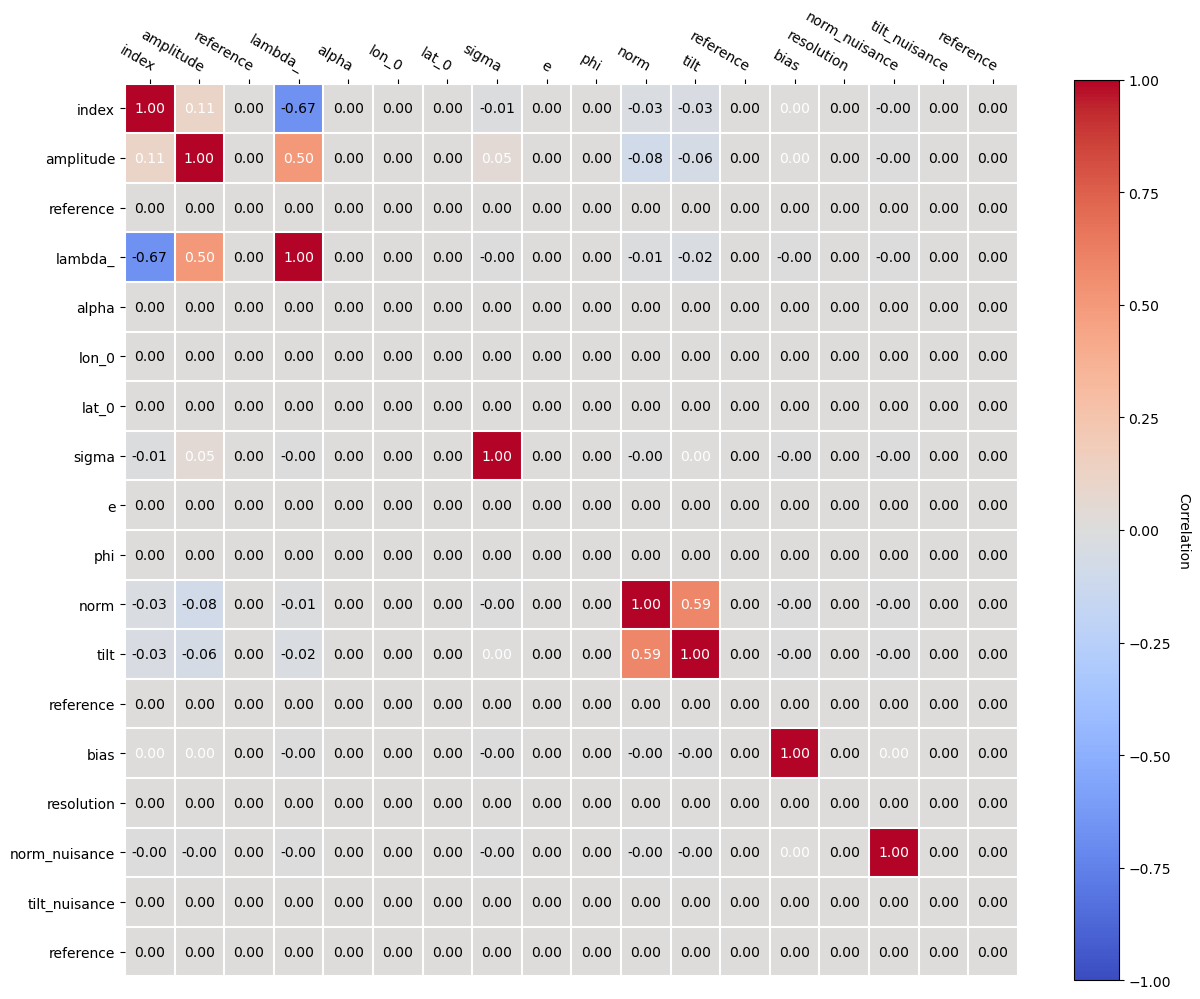

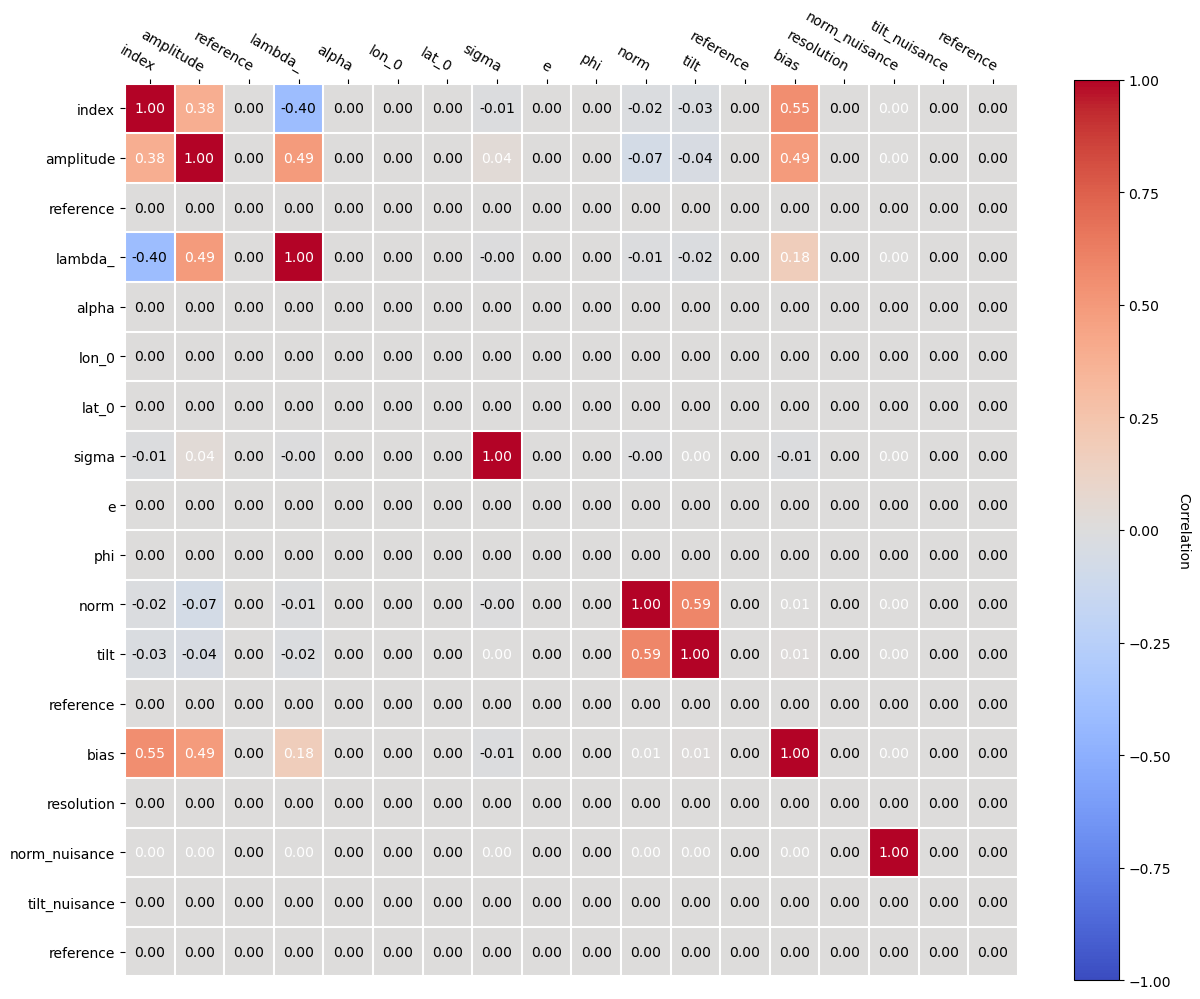

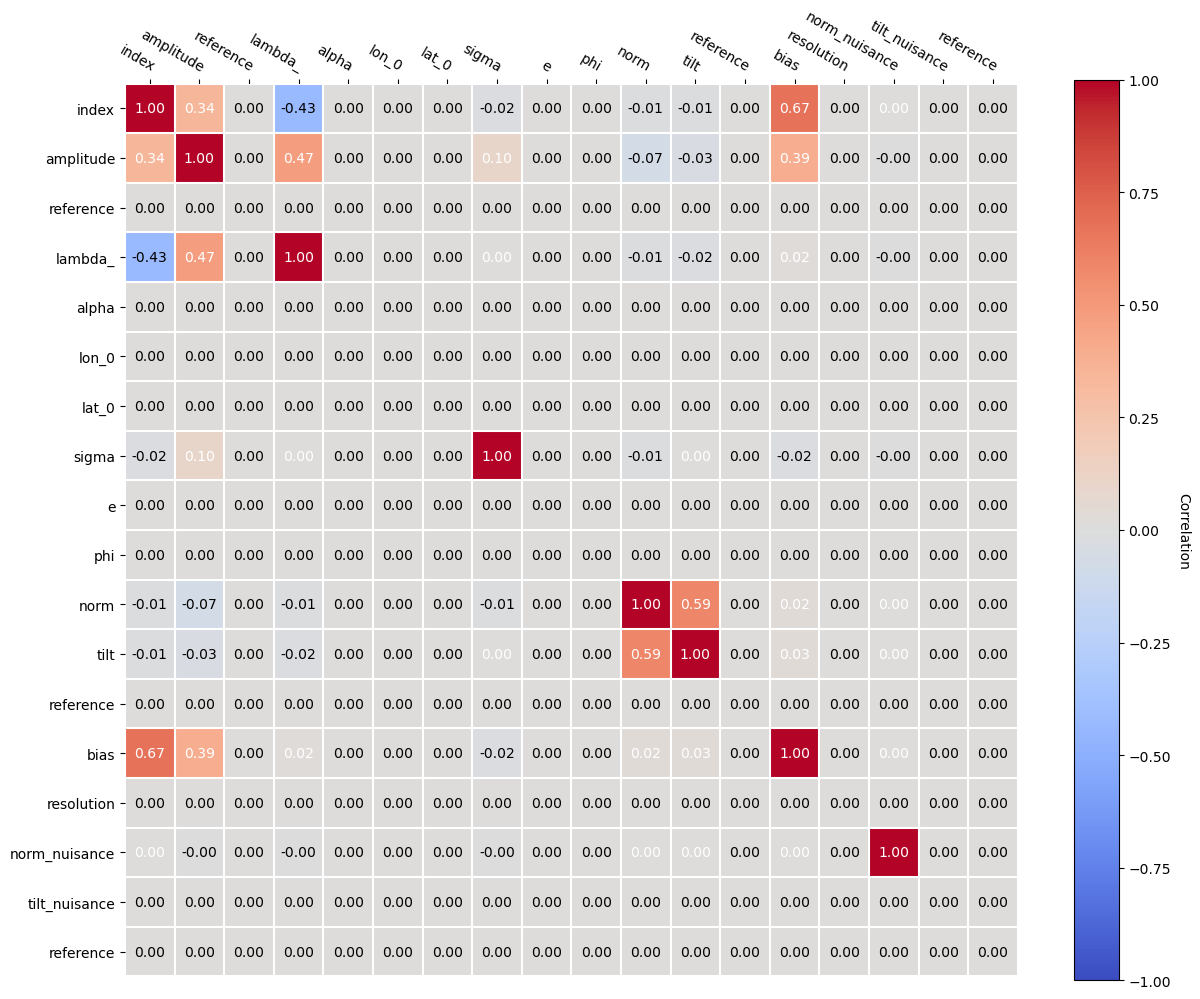

In [16]:
%%time
fitting = 1

if fitting:

    print("corr")
    for d in datasets_conv:
        fit_cor = Fit(store_trace=True)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(d)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor.minuit)

    for d in datasets_conv_N:
        fit_cor_N = Fit(store_trace=True)
        fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
        result_cor_N = fit_cor_N.run(d)
        d.models.covariance = fit_cor_N.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor_N.minuit)
    
    print("saving")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[i]}_sigma_0.yml'
        d.models.write(path,overwrite=True)
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[i]}_sigma_0.yml'
        d.models.write(path,overwrite=True)
        
else:
    print("read")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[i]}_sigma_0.yml'
        datasets_conv[i] = Dataset_load.load_dataset_N(d, path)        
    print("read nui")
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[i]}_sigma_0.yml'
        datasets_conv_N[i] = Dataset_load.load_dataset_N(d, path)        
        
    



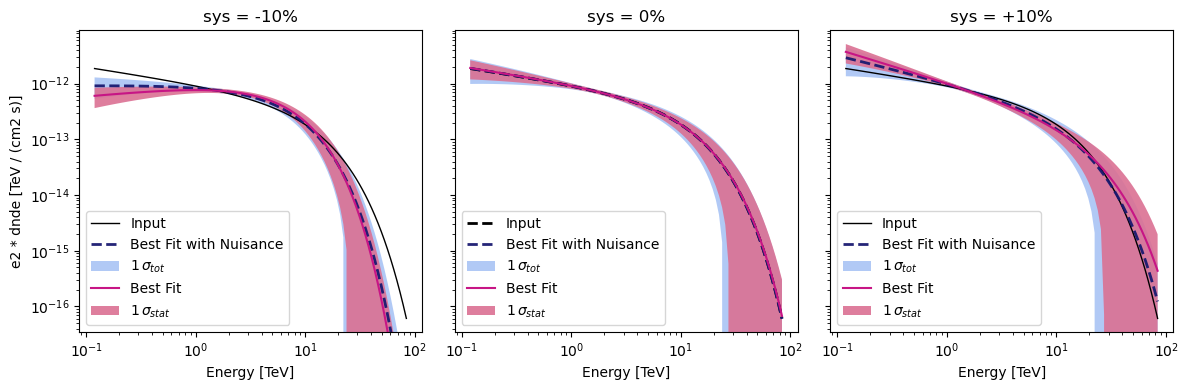

In [17]:
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )
        
for i in range(len(datasets_conv_N)):
    
    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_nui_e,
                                                             label="1$\,\sigma_{tot}$",
                                                            alpha = 0.5)
    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_standard_e,
                                                              alpha = 0.9,
                                                              label= "1$\,\sigma_{stat}$"
                                                             )
[a.legend(loc = 'lower left') for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.svg")

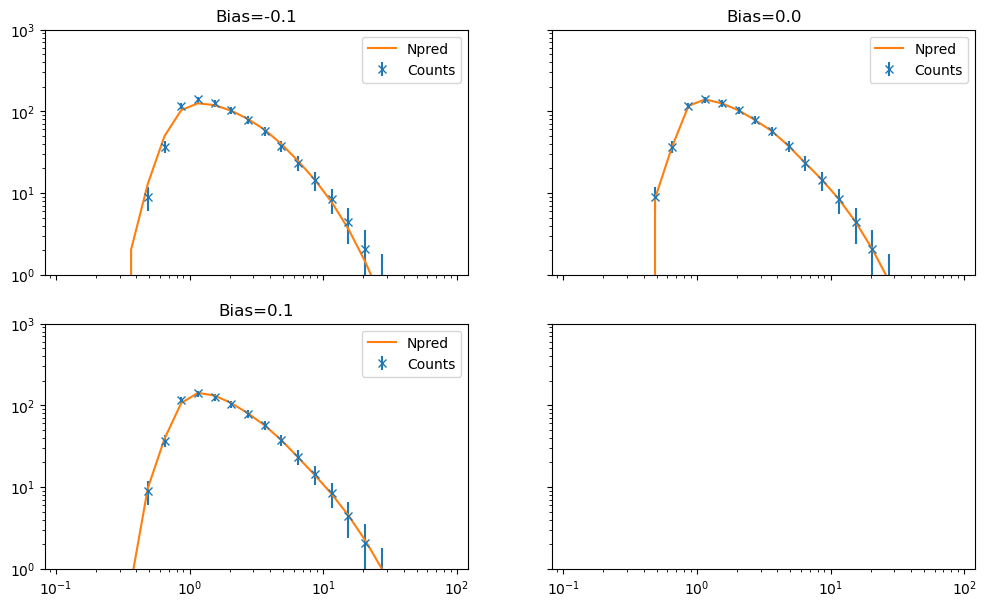

In [19]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_title(f"Bias={b}")
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


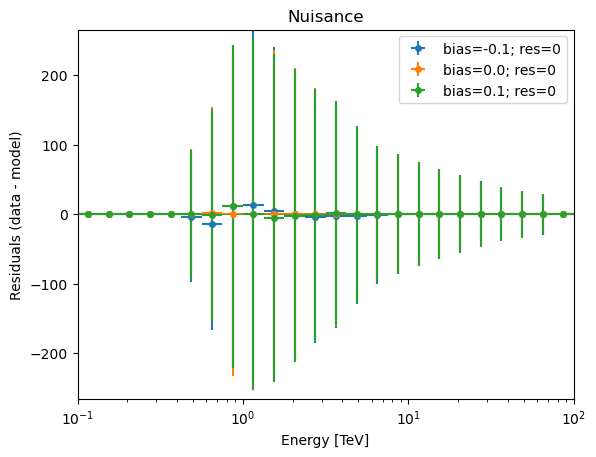

In [20]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Nuisance")

fig.savefig(f"plots/2_Residual_post_fit.svg")

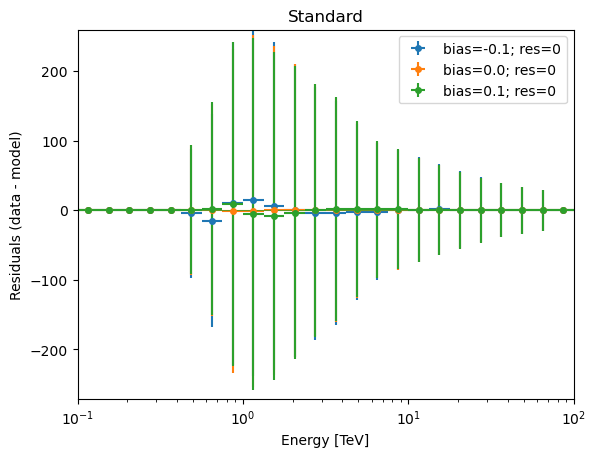

In [21]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Standard")
fig.savefig(f"plots/2_Residual_post_fit_standard.svg")

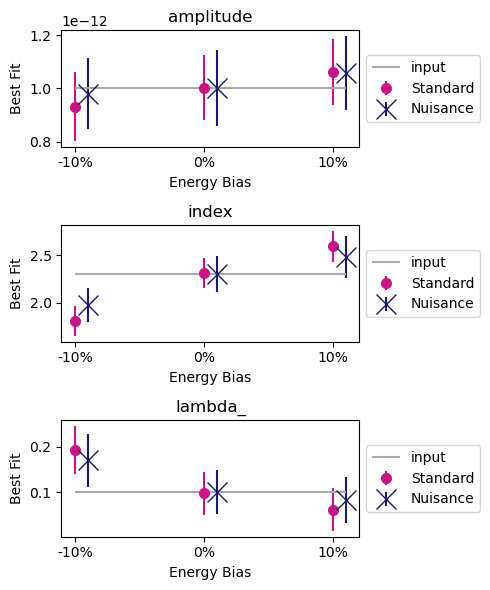

In [22]:
fig, axs = plt.subplots(3,1, figsize= (5, 6))
ax = axs.flatten()


parnames = ['amplitude', 'index', 'lambda_']
ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_standard,markersize = 7,
                          label = f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.1), value, yerr = error, fmt = 'x', color = color_nui,markersize=14,
                          label ="Nuisance")
            
        ii +=1
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1+0.1, label = "input", color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
fig.savefig(f"plots/2_Best_fit_parameters.svg")
    

In [ ]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_nui)
            ax[i].set_title(p)
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = 0
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1,  color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
fig.savefig(f"plots/2_Best_fit_nui_parameters.svg")
    